In [78]:
import pandas as pd
import numpy as np

df = pd.read_csv("data/Twitter/hate_twitter/train_clean.csv")

In [56]:
print(df.shape)
df.head()

(31962, 8)


,Unnamed: 0,id,label,tweet,hash_tag,clean_tweet,tokenized_tweet,tokenized_tweet_NLTK
0,0,1,0,@user when a father is dysfunctional and is s...,['run'],father dysfunctional selfish drags kids dysfun...,<user> when a father is dysfunctional and is ...,@user father dysfunctional selfish drags kids ...
1,1,2,0,@user @user thanks for #lyft credit i can't us...,"['lyft', 'disapointed', 'getthanked']",thanks lyft credit cant use cause dont offer w...,<user> <user> thanks for <hashtag> lyft credit...,@user @user thanks lyft credit can't use cause...
2,2,3,0,bihday your majesty,[],bihday majesty,bihday your majesty,bihday majesty
3,3,4,0,#model i love u take with u all the time in ...,['model'],model love take time ur,<hashtag> model <elong>i love u take with u a...,model love take time urð
4,4,5,0,factsguide: society now #motivation,['motivation'],factsguide society motivation,factsguide: society now <hashtag> motivation,factsguide society motivation


In [5]:
!pip install torchtext==0.11.2
import torchtext
from torchtext.vocab import Vectors
import torch
import random

In [ ]:
BATCH_SIZE = 32
EMBEDDING_SIZE = 650
MAX_VOCAB_SIZE = 50000

In [9]:
import torch
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenizer_language = 'en_core_web_sm')
LABEL = data.LabelField(dtype = torch.float)

In [91]:
df = df[df['clean_tweet'].notna()]
print(df.shape)
df

(31932, 8)


,Unnamed: 0,id,label,tweet,hash_tag,clean_tweet,tokenized_tweet,tokenized_tweet_NLTK
0,0,1,0,@user when a father is dysfunctional and is s...,['run'],father dysfunctional selfish drags kids dysfun...,<user> when a father is dysfunctional and is ...,@user father dysfunctional selfish drags kids ...
1,1,2,0,@user @user thanks for #lyft credit i can't us...,"['lyft', 'disapointed', 'getthanked']",thanks lyft credit cant use cause dont offer w...,<user> <user> thanks for <hashtag> lyft credit...,@user @user thanks lyft credit can't use cause...
2,2,3,0,bihday your majesty,[],bihday majesty,bihday your majesty,bihday majesty
3,3,4,0,#model i love u take with u all the time in ...,['model'],model love take time ur,<hashtag> model <elong>i love u take with u a...,model love take time urð
4,4,5,0,factsguide: society now #motivation,['motivation'],factsguide society motivation,factsguide: society now <hashtag> motivation,factsguide society motivation
...,...,...,...,...,...,...,...,...
31957,31957,31958,0,ate @user isz that youuu?ðððððð...,[],ate isz youuu,ate <user> isz that you <elong>?ðððð...,ate @user isz youuu
31958,31958,31959,0,to see nina turner on the airwaves trying to...,"['shame', 'imwithher']",see nina turner airwaves trying wrap mantle ge...,to see nina turner on the airwaves trying to...,see nina turner airwaves trying wrap mantle ge...
31959,31959,31960,0,listening to sad songs on a monday morning otw...,[],listening sad songs monday morning otw work sad,listening to sad songs on a monday morning otw...,listening sad songs monday morning otw work sad
31960,31960,31961,1,"@user #sikh #temple vandalised in in #calgary,...","['sikh', 'temple', 'calgary', 'wso']",sikh temple vandalised calgary wso condemns act,<user> <hashtag> sikh <hashtag> temple vandali...,@user sikh temple vandalised calgary wso conde...


In [95]:
with open('output.txt', 'w') as f:
    f.write(df['clean_tweet'].str.cat(sep='\n'))

with open('labels.txt', 'w') as f:
    f.write(df['label'].apply(str).str.cat(sep='\n'))

In [96]:
with open('output.txt', 'r') as f:
    tweets = f.read()
with open('labels.txt', 'r') as f:
    labels = f.read()

In [61]:
tweets

'father dysfunctional selfish drags kids dysfunction run\nthanks lyft credit cant use cause dont offer wheelchair vans pdx disapointed getthanked\nbihday majesty\nmodel love take time ur\nfactsguide society motivation\n22 huge fan fare big talking leave chaos pay disputes get allshowandnogo\ncamping tomorrow danny\nnext school year year exams cant think school exams hate imagine actorslife revolutionschool girl\nlove land allin cavs champions cleveland clevelandcavaliers\nwelcome im gr8\nireland consumer price index mom climbed previous 02 05 may blog silver gold forex\nselfish orlando standwithorlando pulseshooting orlandoshooting biggerproblems selfish heabreaking values love\nget see daddy today 80days gettingfed\ncnn calls michigan middle school build wall chant tcot\ncomment australia opkillingbay seashepherd helpcovedolphins thecove helpcovedolphins\nouchjunior angrygot7 junior yugyoem omg\nthankful paner thankful positive\nretweet agree\nfriday smiles around via ig user cookies 

In [99]:
tweets_split = tweets.split('\n')
print ('Number of tweets :', len(tweets_split))

Number of tweets : 31932


In [100]:
from collections import Counter
all_text2 = ' '.join(tweets_split)
# create a list of words
words = all_text2.split()
# Count all the words using Counter Method
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)

In [84]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}
vocab_to_int

{'love': 1,
 'day': 2,
 'happy': 3,
 'im': 4,
 'life': 5,
 'time': 6,
 'like': 7,
 'today': 8,
 'new': 9,
 'positive': 10,
 'thankful': 11,
 'get': 12,
 'people': 13,
 'bihday': 14,
 'good': 15,
 'cant': 16,
 'one': 17,
 'see': 18,
 'dont': 19,
 'fathers': 20,
 'smile': 21,
 'go': 22,
 'want': 23,
 'take': 24,
 'work': 25,
 'healthy': 26,
 'fun': 27,
 'weekend': 28,
 'summer': 29,
 'make': 30,
 'got': 31,
 'family': 32,
 'friday': 33,
 'best': 34,
 'us': 35,
 'need': 36,
 'beautiful': 37,
 'great': 38,
 'way': 39,
 'bull': 40,
 'friends': 41,
 'days': 42,
 'going': 43,
 'first': 44,
 'really': 45,
 'wait': 46,
 'morning': 47,
 'music': 48,
 'ur': 49,
 'back': 50,
 'world': 51,
 'know': 52,
 'fathersday': 53,
 'tomorrow': 54,
 'cute': 55,
 'sad': 56,
 'never': 57,
 'week': 58,
 'orlando': 59,
 'think': 60,
 'happiness': 61,
 'feel': 62,
 'blog': 63,
 'sunday': 64,
 'well': 65,
 'home': 66,
 'much': 67,
 'model': 68,
 'right': 69,
 'trump': 70,
 'night': 71,
 'affirmation': 72,
 'girl': 

In [85]:
tweets_int = []
for tweet in tweets_split:
    r = [vocab_to_int[w] for w in tweet.split()]
    tweets_int.append(r)
print (tweets_int[0:3])

[[162, 15242, 3099, 6136, 157, 7546, 347], [92, 5218, 2225, 16, 320, 506, 19, 1350, 7547, 9788, 7548, 15243, 9789], [14, 3100]]


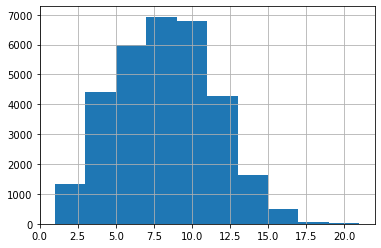

count    31932.000000
mean         7.754541
std          3.203309
min          1.000000
25%          5.000000
50%          8.000000
75%         10.000000
max         21.000000
dtype: float64

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
tweets_len = [len(x) for x in tweets_int]
pd.Series(tweets_len).hist()
plt.show()
pd.Series(tweets_len).describe()

In [70]:
def pad_features(tweets_int, seq_length):
    ''' 
    Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(tweets_int), seq_length), dtype = int)
    
    for i, tweet in enumerate(tweets_int):
        tweet_len = len(tweet)
        
        if tweet_len <= seq_length:
            zeroes = list(np.zeros(seq_length-tweet_len))
            new = zeroes+tweet
        elif tweet_len > seq_length:
            new = tweet[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

In [202]:
df2 = pad_features(tweets_int, 10)
df2

array([[   0,    0,    0, ...,  157, 7546,  347],
       [  92, 5218, 2225, ..., 1350, 7547, 9788],
       [   0,    0,    0, ...,    0,   14, 3100],
       ...,
       [   0,    0,  928, ..., 7277,   25,   56],
       [   0,    0,    0, ..., 1422, 1423,  538],
       [   0,    0,    0, ...,    0,   89,   82]])

In [97]:
labels = labels.split('\n')
encoded_labels = [1 if label =='1' else 0 for label in labels]


In [98]:
len(encoded_labels)

31932

In [151]:
import torch
from torch.utils.data import DataLoader, TensorDataset

encoded_labels = np.array(encoded_labels)

train_data = TensorDataset(torch.from_numpy(df2), torch.from_numpy(encoded_labels))

batch_size = 50
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [152]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)


Sample input size:  torch.Size([50, 10])
Sample input: 
 tensor([[    0,     0,   102,  1182,  1348, 12814,  1184,  2601,   419, 12815],
        [    0,     0,     0,     0,     0,     0,     0,   599,     9,    58],
        [ 3620,  1759,  3971,  4650,   744,  3972,  5788,   550,   237,   320],
        [33578,   147,   127,   122,   221,   160,   147,   127,   122,   221],
        [    0,     0,     0,   314,  4933,  4376,   342,  3620,   102,  6020],
        [    0,     0,     0,     0,   143,   229,   229,   501,   374,   278],
        [    0,     0,   120,    62,     7,   797,   289,   326,  1055,   502],
        [    0, 27752,   262, 27753,    67,   191,   166,  5095,   857,    22],
        [    0,     0,     0,     0,  4205,   121,  1093,     9,   120,  2794],
        [    0,     0,     0,   900,  8226,    43,   270,  3052, 34693,   699],
        [    0,     0,     0,     0,     0,    11,  3194,  7015,    11,    10],
        [    0,     0,     0,     0, 27220,   394,  2640,  1609

In [214]:
import torch
import torch.nn as nn


class LSTM(nn.Module):
    """ Container module with an linear encoder/embedding, an RNN module, and a linear decoder.
    """

    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, dropout=0):
        ''' Initialize model parameters corresponding to ---
            - embedding layer
            - linear layer to map from hidden vector to the vocabulary
            - optionally, dropout layers.  Dropout layers can be placed after 
              the embedding layer or/and after the RNN layer. Dropout within
              an RNN is only applied when there are two or more num_layers.
            - optionally, initialize the model parameters.
            
            The arguments are:
            
            vocab_size: size of vocabulary
            embedding_dim: size of an embedding vector
            hidden_dim: size of hidden/state vector in RNN
            num_layers: number of layers in RNN
            dropout: dropout probability.
            
        '''
        super(LSTM, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.vocab_size = vocab_size
        self.embed_size = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.word_embeddings = nn.Embedding(self.vocab_size, self.embed_size)
        self.rnn = nn.LSTM(self.embed_size, self.hidden_dim, self.n_layers, batch_first=True)
        self.hidden2tag = nn.Linear(self.hidden_dim, 1)
        

    def forward(self, input, hidden0):
        ''' 
        Run forward propagation for a given minibatch of inputs using
        hidden0 as the initial hidden state.

        In LSTMs hidden0 = (h_0, c_0). 

        The output of the RNN includes the hidden vector hiddenn = (h_n, c_n).
        Return this as well so that it can be used to initialize the next
        batch.
        
        Unlike previous homework sets do not apply softmax or logsoftmax here, since we'll use
        the more efficient CrossEntropyLoss.  See 
        https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.
        '''
        batch_size = input.size(0)
        embeds = self.word_embeddings(input)
        print(hidden0[0].shape)
        lstm_out, hidden_new = self.rnn(embeds, hidden0)
#         lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        tag_space = self.hidden2tag(lstm_out)
        print(tag_space.shape)
#       sig_out = tag_space.view(batch_size, -1)
        tag_space = tag_space[:, -1]
        print(tag_space.shape)

        return tag_space, hidden_new


    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
#         if (train_on_gpu):
#             hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
#                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
#         else:
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [215]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

    
model = LSTM(vocab_size, embedding_dim, hidden_dim, n_layers)
print(model)

41280
LSTM(
  (dropout): Dropout(p=0, inplace=False)
  (word_embeddings): Embedding(41280, 400)
  (rnn): LSTM(400, 256, num_layers=2, batch_first=True)
  (hidden2tag): Linear(in_features=256, out_features=1, bias=True)
)


In [132]:
batch_size

50

In [218]:
# loss and optimization functions
lr=0.001

criterion =nn.BCELoss()
loss_function = torch.nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# training params

epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing
counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
# if(train_on_gpu):
#     model.cuda()

model.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = model.init_hidden(batch_size)
    
    # batch loop
    for inputs, labels in train_loader:
        counter += 1

#         if(train_on_gpu):
#             inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        model.zero_grad()

        # get the output from the model
        inputs = inputs.type(torch.LongTensor)
        output, h = model(inputs, h)

        # calculate the loss and perform backprop
        print(output.squeeze().shape, labels.shape)
        loss = loss_function(output.squeeze(), labels)
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

#                 if(train_on_gpu):
#                     inputs, labels = inputs.cuda(), labels.cuda()

                inputs = inputs.type(torch.LongTensor)
                output, val_h = model(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels)

                val_losses.append(val_loss.item())

            model.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

torch.Size([2, 50, 256])
torch.Size([50, 10, 1])
torch.Size([50, 1])
torch.Size([50]) torch.Size([50])
torch.Size([2, 50, 256])
torch.Size([50, 10, 1])
torch.Size([50, 1])
torch.Size([50]) torch.Size([50])
torch.Size([2, 50, 256])
torch.Size([50, 10, 1])
torch.Size([50, 1])
torch.Size([50]) torch.Size([50])
torch.Size([2, 50, 256])
torch.Size([50, 10, 1])
torch.Size([50, 1])
torch.Size([50]) torch.Size([50])
torch.Size([2, 50, 256])
torch.Size([50, 10, 1])
torch.Size([50, 1])
torch.Size([50]) torch.Size([50])
torch.Size([2, 50, 256])
torch.Size([50, 10, 1])
torch.Size([50, 1])
torch.Size([50]) torch.Size([50])
torch.Size([2, 50, 256])
torch.Size([50, 10, 1])
torch.Size([50, 1])
torch.Size([50]) torch.Size([50])
torch.Size([2, 50, 256])
torch.Size([50, 10, 1])
torch.Size([50, 1])
torch.Size([50]) torch.Size([50])
torch.Size([2, 50, 256])
torch.Size([50, 10, 1])
torch.Size([50, 1])
torch.Size([50]) torch.Size([50])
torch.Size([2, 50, 256])
torch.Size([50, 10, 1])
torch.Size([50, 1])
torc

KeyboardInterrupt: 

In [176]:
loss_function = nn.CrossEntropyLoss()

def train_an_epoch(dataloader):
    
    ### WRITE YOUR CODE BELOW
    model.train() # Sets the module in training mode.
    log_interval = 500
    hidden = model.init_hidden(batch_size)
    for idx, (text,label) in enumerate(dataloader):
        model.zero_grad() #initialize to 0 gradient
        out, hidden = model(text, hidden) #picking forward method
        loss = loss_function(out.view(-1, vocab_size), label.view(-1)) #calcs the loss
        loss.backward() #backpropogation
        optimizer.step() #changing the gradient descent
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

In [166]:
def get_accuracy(dataloader):
    model.eval()
    with torch.no_grad():    
        total_acc, total_count = 0, 0
        for idx, (label, word_idxs) in enumerate(dataloader):
            log_probs = model(word_idxs)
            total_acc += (log_probs.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [177]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 3 # epoch
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_loader)
    accuracy = get_accuracy(train_loader)
    accuracies.append(accuracy)
    time_taken = time.time() - epoch_start_time
    print(f'Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: {accuracy:.3f}.')
    
plt.plot(range(1, EPOCHS+1), accuracies)

torch.Size([2, 50, 256])


ValueError: Expected input batch_size (500) to match target batch_size (50).